# Sentiment analysis using recurrent neural networks (RNNs)

One of the common uses for binary classification in machine learning is analyzing text for sentiment — specifically, assigning a text string a score from 0 to 1, where 0 represents negative sentiment and 1 represents positive sentiment. A restaurant review such as "Best meal I've ever had and awesome service, too!" might score 0.9 or higher, while a statement such as "Long lines and poor customer service" would score closer to 0. Marketing departments sometimes use sentiment-anlysis models to monitor social-media services for feedback so they can respond quickly if, for example, comments regarding their company suddenly turn negative.

To train a neural network to perform sentiment analysis, you need a dataset containing text strings labeled with 0s (for negative sentiment) and 1s (for positive sentiment). Several such datasets are available in the public domain. We will use one containing 50,000 movie reviews, each labeled with a 0 or 1. Once the network is trained, scoring a text string for sentiment is a simple matter of passing it to the network and asking for the probability that the predicted label is 1. A probability of 80% means the sentiment score is 0.8 and that the text is very positive.

![](Images/sentiment.jpg)

The network that we'll train in this example is a [recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network), which use connections between nodes to "remember" words previously seen in training text and lend context to text analysis that is missing in conventional neural networks.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in machine learning. Because machine-learning models can't deal with raw text, we'll use Keras's [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to tokenize the training text. And because Keras doesn't include support for removing stop words as Scikit-learn does, we'll use the [Natural Language Tookit](https://www.nltk.org/) (NLTK) to remove stop words such as "the" and "a." Then we'll split the data for training and testing.

In [1]:
import pandas as pd

df = pd.read_csv('Data/reviews.csv', encoding="ISO-8859-1")
df.head()

,Text,Sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


Find out how many rows the dataset contains and confirm that there are no missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


Check for duplicate rows in the dataset.

In [3]:
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          25000  24697  You do realize that you've been watching the E...   
1          25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
Sentiment       
0            3  
1            5

The dataset contains a few hundred duplicate rows. Let's remove them and check for balance.

In [4]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  I turned this off about 50 minutes into it! Wh...   
1          24884  24884  Dolelemite (1975) is a cult classic. Starring ...   

                
          freq  
Sentiment       
0            1  
1            1

Define a function for cleaning text by removing punctuation characters, converting characters to lowercase, and removing stop words. Then use it to clean the reviews in the DataFrame's "Text" column.

In [5]:
import string
from nltk.corpus import stopwords

def clean_text(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.lower().split(' ')
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
x = df.apply(lambda row: clean_text(row['Text']), axis=1)
y = df['Sentiment']

Use Keras's [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to tokenize the cleaned text, and then created padded sequences holding up to 500 tokens each.

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 50000
max_review_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_review_length)

Split the padded sequences and the labels for training and testing.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.5, random_state=0) 

## Train a recurrent neural network

It's easy enough now to build a neural network and train it with the tokenized text sequences. Note the [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer, which takes the sequences and packs them into dense vectors of a specified size, and the [`LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/) layer, which gives the network "memory" by maintaining internal state that encodes information about data seen thus far.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding

model = Sequential() 
model.add(Embedding(max_words, 32, input_length=max_review_length)) 
#model.add(LSTM(32, return_sequences=True)) # Uncomment this to try two LSTM layers
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,608,353
Trainable params: 1,608,353
Non-trainable params: 0
_________________________________________________________________


Train the network and capture the training history returned by `fit`.

In [9]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=250)

Epoch 1/5
100/100 [==============================] - 49s 495ms/step - loss: 0.6413 - accuracy: 0.7040 - val_loss: 0.4584 - val_accuracy: 0.8385
Epoch 2/5
100/100 [==============================] - 46s 463ms/step - loss: 0.3039 - accuracy: 0.8854 - val_loss: 0.2944 - val_accuracy: 0.8837
Epoch 3/5
100/100 [==============================] - 48s 480ms/step - loss: 0.1573 - accuracy: 0.9473 - val_loss: 0.3100 - val_accuracy: 0.8869
Epoch 4/5
100/100 [==============================] - 49s 495ms/step - loss: 0.0872 - accuracy: 0.9756 - val_loss: 0.3508 - val_accuracy: 0.8777
Epoch 5/5
100/100 [==============================] - 51s 510ms/step - loss: 0.0501 - accuracy: 0.9880 - val_loss: 0.3859 - val_accuracy: 0.8767


See how the training and validation accuracy evolved and make sure the network was trained for a sufficient number of epochs.

[]

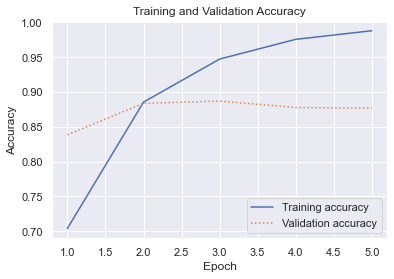

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Use a confusion matrix to see how the model scored on the test data.

Text(89.133125, 0.5, 'Predicted label')

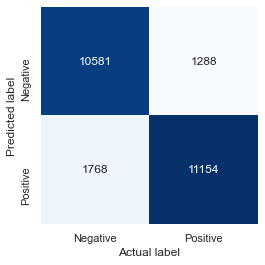

In [11]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Negative', 'Positive']

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Actual label')
plt.ylabel('Predicted label')

## Use the model to analyze text

Let's score a couple of reviews by tokenizing them and passing them to the model's `predict` method. Start with a positive review.

In [12]:
cleaned_text = clean_text('One of the more delightful experiences I have had!')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_review_length)
model.predict(padded_sequence)[0][0]

0.85171986

And then a negative review.

In [13]:
cleaned_text = clean_text('The long lines and poor customer service really turned me off.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_review_length)
model.predict(padded_sequence)[0][0]

0.09172019

Do the sentiment scores output by the model seem accurate?